# Projet 6 : Classifiez automatiquement des biens de consommation.

## Classification supervisée des images avec EfficientNet

## <font color='red'>1. Préparation de l'environnement</font><a class="anchor" id="partie2"></a>

### <font color='purple'> Préparation des données et des fonctions</font>

In [ ]:
!pip install tensorflow

In [ ]:
!pip install --upgrade tensorflow keras

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
from tensorflow.keras.applications import efficientnet_v2, EfficientNetV2M
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Charger le fichier CSV dans un data frame
df = pd.read_csv('/content/drive/My Drive/projet_6/df_classification_copy.csv')

In [ ]:
# Définir le chemin de base des images
chemin_images = '/content/drive/My Drive/projet_6/Images/'

In [ ]:
def plot_learning_curves(history):
    """
    Trace les courbes d'apprentissage pour la précision et la perte du modèle
    en utilisant l'historique de l'entraînement (history).
    """
    # Précision du modèle
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['accuracy'], label=f'Train Accuracy: {history.history["accuracy"][-1]:.4f}')
    plt.plot(history.history['val_accuracy'], label=f'Val Accuracy: {history.history["val_accuracy"][-1]:.4f}')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Perte du modèle (loss)
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label=f'Train Loss: {history.history["loss"][-1]:.4f}')
    plt.plot(history.history['val_loss'], label=f'Val Loss: {history.history["val_loss"][-1]:.4f}')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

In [ ]:
def plot_confusion_matrix(conf_matrix, categories):
    """
    Affiche une matrice de confusion sous forme de heatmap.

    Args:
    conf_matrix : ndarray
        La matrice de confusion.
    categories : list
        Les catégories ou labels des classes.
    """
    df_cm = pd.DataFrame(conf_matrix, index=categories, columns=categories)
    plt.figure(figsize=(8, 6))
    sns.heatmap(df_cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()

In [ ]:
def image_prep_fct(list_photos, model='EfficientNet'):
    '''Préparation des images pour la modélisation.'''
    prepared_images = []

    for image_num in range(len(list_photos)) :
        img = (load_img(chemin_images + list_photos[image_num], target_size=(224, 224)))
        img = img_to_array(img)
        img = img.reshape((img.shape[0], img.shape[1], img.shape[2]))
        if model == 'EfficientNet':
            img = efficientnet_v2.preprocess_input(img)
        else:
            img = convnext.preprocess_input(img)

        prepared_images.append(img)

    prepared_images_np = np.array(prepared_images)
    return prepared_images_np

## <font color='red'>2. EfficientNet</font><a class="anchor" id="partie2"></a>

In [ ]:
# Séparer le jeu de données en entraînement et test
X_train, X_test, y_train, y_test = train_test_split(df['image'], df['cat_1'], test_size=0.2, random_state=0)

# Transformer les listes en listes d'images utilisables
X_train = list(X_train)
X_test = list(X_test)

In [ ]:
# Préparation des images pour l'entraînement et le test
images_np_train = image_prep_fct(X_train, 'EfficientNet')
images_np_test = image_prep_fct(X_test, 'EfficientNet')

/usr/local/lib/python3.10/dist-packages/PIL/Image.py:3368: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


In [ ]:
y_train_categorical = to_categorical(LabelEncoder().fit_transform(y_train), num_classes=7)
y_test_categorical = to_categorical(LabelEncoder().fit_transform(y_test), num_classes=7)

In [ ]:
def create_model_fct(model_base, loss="categorical_hinge", opti='adam', option=True):
    '''Création du modèle basé sur EfficientNetV2 avec des ajustements spécifiques.'''

    for layer in model_base.layers:
        layer.trainable = False

    x = model_base.output
    x = GlobalAveragePooling2D()(x)
    x = Dense(256, activation='relu')(x)
    x = Dropout(0.5)(x)
    predictions = Dense(7, activation='softmax')(x)

    model = Model(inputs=model_base.input, outputs=predictions)
    model.compile(optimizer=opti, loss=loss, metrics=['accuracy'])

    if option:
        model.summary()

    return model

# Charger EfficientNetV2 et créer le modèle
model_base = EfficientNetV2M(include_top=False, weights="imagenet", input_shape=(224, 224, 3))
model_efficient = create_model_fct(model_base, loss='categorical_hinge', opti='adam')

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 224, 224, 3)    │              0 │ input_layer_3[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 112, 112, 24)   │            648 │ rescaling_3[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 112, 112, 24)   │             96 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 112, 112, 24)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_conv      │ (None, 112, 112, 24)   │          5,184 │ stem_activation[0][0]  │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_bn        │ (None, 112, 112, 24)   │             96 │ block1a_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_project_activati… │ (None, 112, 112, 24)   │              0 │ block1a_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1a_project_activ… │
│                           │                        │                │ stem_activation[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_conv      │ (None, 112, 112, 24)   │          5,184 │ block1a_add[0][0]      │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_bn        │ (None, 112, 112, 24)   │             96 │ block1b_project_conv[… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_project_activati… │ (None, 112, 112, 24)   │              0 │ block1b_project_bn[0]… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_drop (Dropout)    │ (None, 112, 112, 24)   │              0 │ block1b_project_activ… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1b_add (Add)         │ (None, 112, 112, 24)   │              0 │ block1b_drop[0][0],    │
│                           │                        │                │ block1a_add[0][0]      │
├──────────────────────

 Total params: 53,480,123 (204.01 MB)

 Trainable params: 329,735 (1.26 MB)

 Non-trainable params: 53,150,388 (202.75 MB)

In [ ]:
# Callbacks pour EarlyStopping et ModelCheckpoint
model_save_path = "/content/best_efficientnet_model.keras"
checkpoint = ModelCheckpoint(model_save_path, monitor='val_loss', verbose=1, save_best_only=True, mode='min')
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
callbacks_list = [checkpoint, early_stop]

# Entraînement du modèle
history_efficient = model_efficient.fit(
    images_np_train, y_train_categorical,
    validation_data=(images_np_test, y_test_categorical),
    epochs=50, batch_size=128, callbacks=callbacks_list, verbose=1
)

Epoch 1/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9697 - loss: 0.0686
Epoch 1: val_loss improved from inf to 0.25072, saving model to /content/best_efficientnet_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 5s 731ms/step - accuracy: 0.9701 - loss: 0.0687 - val_accuracy: 0.8810 - val_loss: 0.2507
Epoch 2/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9713 - loss: 0.0697
Epoch 2: val_loss improved from 0.25072 to 0.23963, saving model to /content/best_efficientnet_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 6s 876ms/step - accuracy: 0.9715 - loss: 0.0693 - val_accuracy: 0.8952 - val_loss: 0.2396
Epoch 3/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 243ms/step - accuracy: 0.9788 - loss: 0.0617
Epoch 3: val_loss improved from 0.23963 to 0.23653, saving model to /content/best_efficientnet_model.keras
7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 689ms/step - accuracy: 0.9789 - loss: 0.0614 - val_accuracy: 0.8905 - val_loss: 0.2365
Epoch 4/50
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 242ms/step - accuracy: 0.9744 - loss: 0.0700
Ep

27/27 ━━━━━━━━━━━━━━━━━━━━ 19s 390ms/step - accuracy: 0.9743 - loss: 0.0516
7/7 ━━━━━━━━━━━━━━━━━━━━ 9s 1s/step - accuracy: 0.8793 - loss: 0.2295
Train Accuracy: 0.9774, Test Accuracy: 0.8762


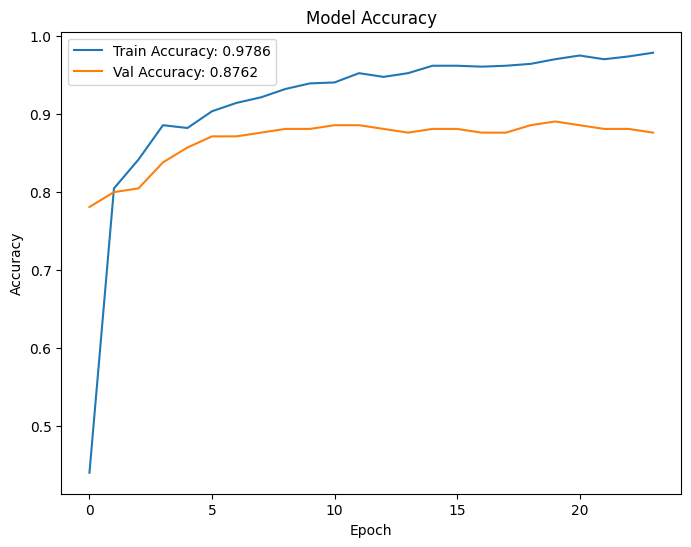

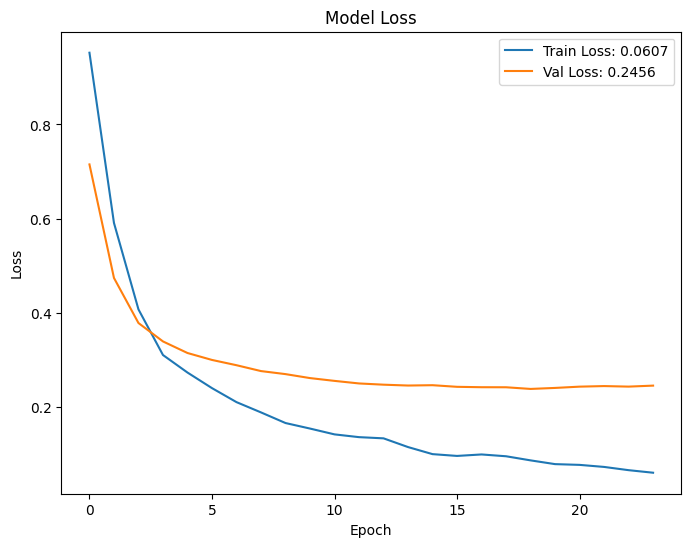

7/7 ━━━━━━━━━━━━━━━━━━━━ 29s 2s/step


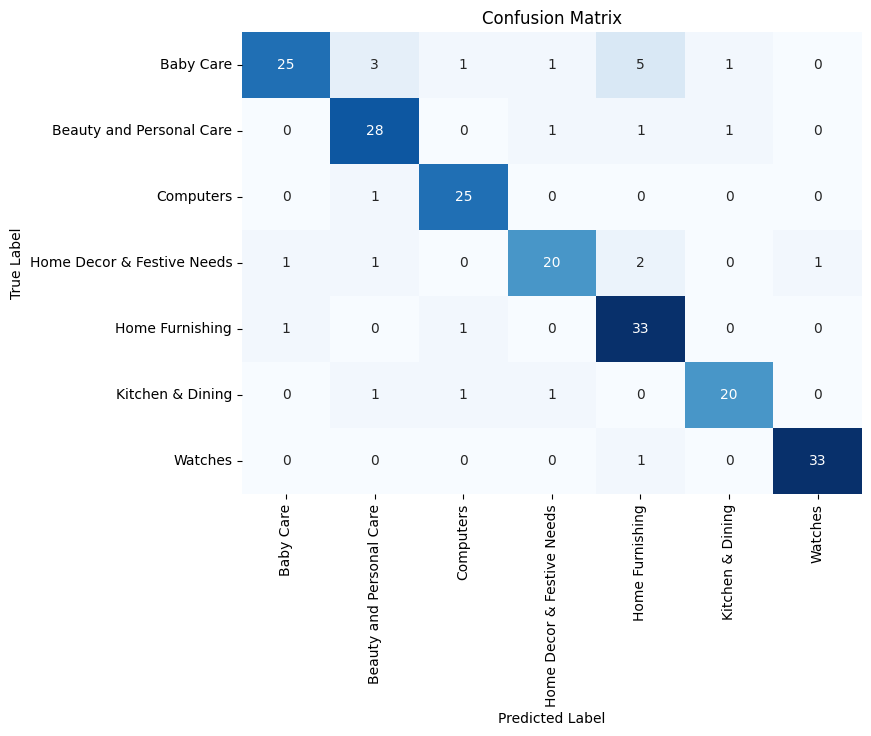

In [ ]:
# Évaluation du modèle
loss_train, acc_train = model_efficient.evaluate(images_np_train, y_train_categorical, verbose=1)
loss_test, acc_test = model_efficient.evaluate(images_np_test, y_test_categorical, verbose=1)
print(f"Train Accuracy: {acc_train:.4f}, Test Accuracy: {acc_test:.4f}")

# Afficher les courbes d'apprentissage
plot_learning_curves(history_efficient)

# Générer et afficher la heatmap de la matrice de confusion
y_pred = np.argmax(model_efficient.predict(images_np_test), axis=1)
y_true = np.argmax(y_test_categorical, axis=1)
conf_matrix = confusion_matrix(y_true, y_pred)
plot_confusion_matrix(conf_matrix, categories=LabelEncoder().fit(df['cat_1']).classes_)

#### <font color='purple'> Observations </font>

- Courbes d'apprentissage
Accuracy : On observe une bonne performance avec une accuracy de 97.86% sur le jeu d'entraînement et une accuracy de 87.62% sur le jeu de validation. Cette différence montre un certain overfitting, car le modèle atteint presque la perfection sur l'ensemble d'entraînement, mais la validation stagne autour de 87%.

- Loss : La courbe de loss montre une convergence efficace, mais le gap entre le loss d'entraînement (0.0607) et le loss de validation (0.2456) confirme également un overfitting. Le modèle a une très bonne performance d'entraînement mais une généralisation limitée sur les nouvelles données.

- Matrice de confusion
La matrice de confusion met en évidence les performances par catégorie :

  - Baby Care et Beauty and Personal Care : Bonne précision avec très peu de confusion. La catégorie "Baby Care" a été prédite correctement pour 25 produits sur 30, avec quelques confusions mineures.
  - Home Furnishing : Catégorie prédite avec un très haut score (33 sur 34) montrant une forte précision.
  - Computers et Watches : Ici aussi, les performances sont excellentes, avec 25 produits et 33 respectivement correctement prédits.
  - Kitchen & Dining et Home Decor & Festive Needs : Quelques confusions persistent, en particulier dans ces catégories où l'on observe des erreurs sur plusieurs produits, ce qui pourrait indiquer une certaine proximité visuelle ou des descripteurs similaires entre ces classes.

- Comparaison avec VGG16 optimisé
Par rapport aux résultats du modèle VGG16 avec optimisation des hyperparamètres, EfficientNet montre des performances légèrement meilleures sur l'ensemble d'entraînement (98% contre 78%) et de validation (87% contre 81%). Cependant, l'overfitting est plus marqué dans EfficientNet, et bien que le modèle semble plus performant en termes d'accuracy brute, il pourrait être moins bien généralisé que VGG16.